Notes about how to condition and process the HAT-P-37 data

In [142]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile

# From https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract
orbital_period = 2.79744256 #±0.00000041 

In [57]:
# Check which lightcurves are available for HAT-P-37
# I can't seem to look the system up except by its TIC number
# exptime='short' only keeps the 120-s exposures
search_result = lk.search_lightcurve("TIC 267572272", author='SPOC', exptime='short')
search_result
klc = search_result.download_all()

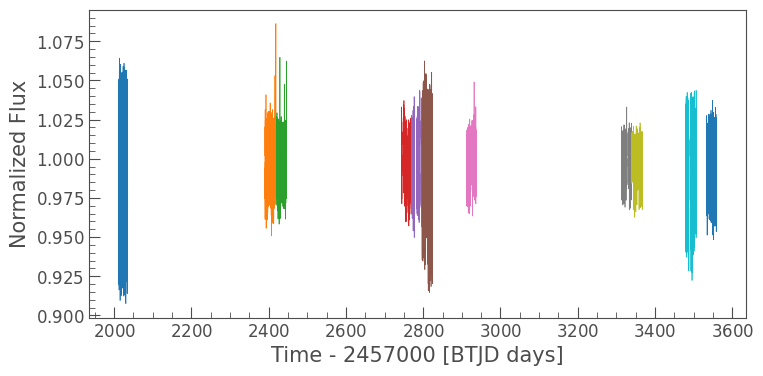

In [148]:
# PDCSAP_FLUX is the mission's estimate for lightcurve with instrument effects taken out
# ax = klc[7].plot(column='pdcsap_flux', label='PDCSAP Flux')
# ax = klc[7].plot(column='sap_flux', normalize=True)

# Suppress the legend because it clutters up the plot.
# klc.plot(column='sap_flux', label='SAP Flux', normalize=True, ax=ax);

ax = klc.plot(normalize=True)
ax.get_legend().remove()

0.21773270629361255 d


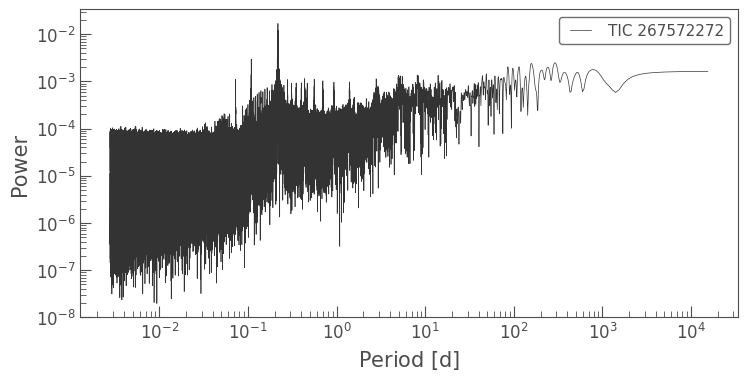

In [156]:
# Make a single lightcurve out of the collection of lightcurves
big_lc = klc.stitch()
# big_lc.scatter();

# We'll focus on the SAP flux because it has the least processing.
# big_lc.select_flux("sap_flux")

# Calculate periodogram
pg = big_lc.to_periodogram(oversample_factor=10)
# help(big_lc.to_periodogram)
ax = pg.plot(view='period', scale='log');
# Find peak - 0.21769631036042894 d
# 
# BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
# so we need to fold on twice on the period
print(pg.period_at_max_power)

/opt/anaconda3/envs/HAT-P-37-Transit-Timing-Analysis/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


26 0.21769631036042894 d
40 0.21776212282926408 d
41 0.21776179083773314 d
53 0.21761555324430532 d
54 0.21766960595701088 d
75 0.2177475947165339 d
80 0.21767482511386935 d
82 0.21779617712240618 d
0.21771549752269398 d


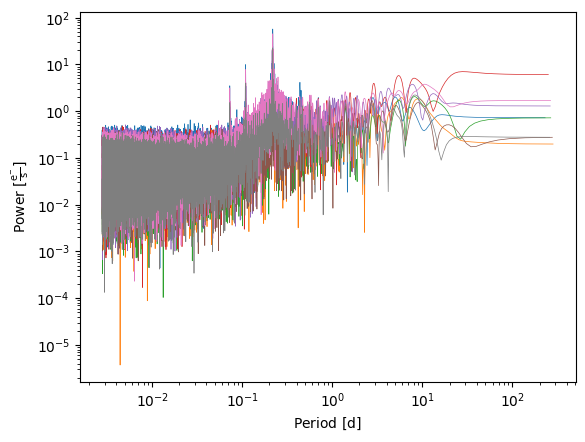

In [155]:
# Running through the LCs

fig = plt.figure()
ax = fig.add_subplot(111)

# Sectors 59 and 74 show an anomalous peak at long periods, so we'll mask them out for the purposes of estimating the period.
average_period = 0.
wellbehaving_list = [*klc[:5], *klc[8:]]
for cur_lc in wellbehaving_list:

    # We'll focus on the SAP flux because it has the least processing.
    cur_lc.select_flux("pdcsap_flux")

    # Calculate periodogram
    pg = cur_lc.to_periodogram(oversample_factor=10)
    # help(big_lc.to_periodogram)
    pg.plot(view='period', scale='log', ax=ax);
    # Find peak - 0.21769631036042894 d
    # 
    # BUT we know that this signal is due to an eclipsing binary, so we should have two eclipses per orbit,
    # so we need to fold on twice on the period
    print(cur_lc.sector, pg.period_at_max_power)

    average_period += pg.period_at_max_power

average_period /= len(wellbehaving_list)
print(average_period)

# ax.set_xlim([1e-1, 1e0])
ax.get_legend().remove()
ax.set_yscale('log')

# 
# 0 26 0.21769631036042894 d
# 1 40 0.21776212282926408 d
# 2 41 0.21776179083773314 d
# 3 53 0.21761555324430532 d
# 4 54 0.21766960595701088 d
# 5 55 0.2176456122389553 d
# 6 59 5.275558515009715 d
# 7 74 0.9337085985818474 d
# 8 75 0.2177475947165339 d
# 9 80 0.21767482511386935 d
# 10 82 0.21779617712240618 d

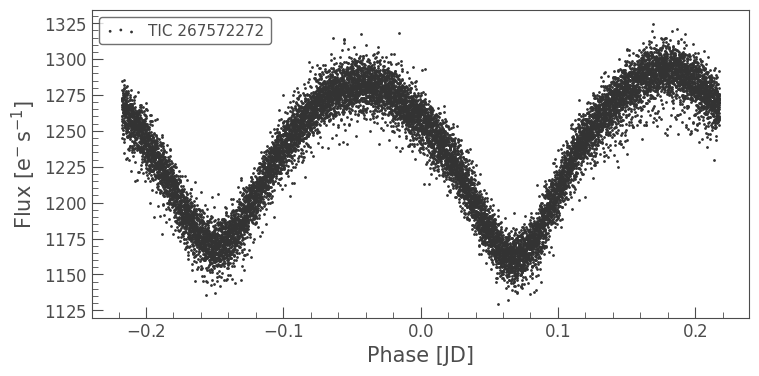

In [161]:
# big_lc.fold(period=2.*average_period).scatter();
folded_lc = klc[0].fold(period=2.*average_period)
folded_lc.scatter();

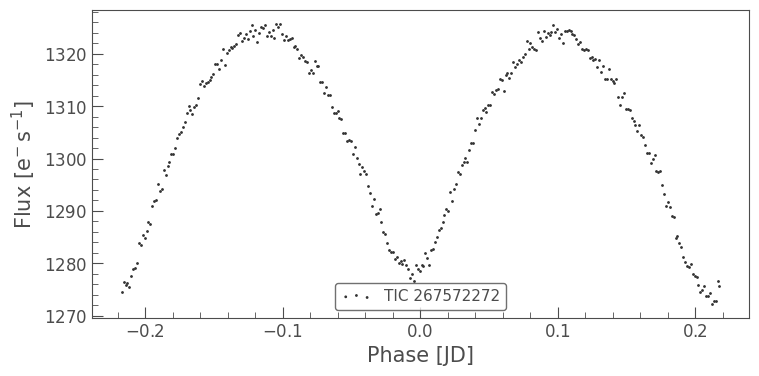

In [137]:
# Now we will calculate the binary eclipse function and de-trend using that.
binsize = 120./86400. # 120 seconds to days
binned_folded_lc = folded_lc.bin(binsize)
binned_folded_lc.scatter();

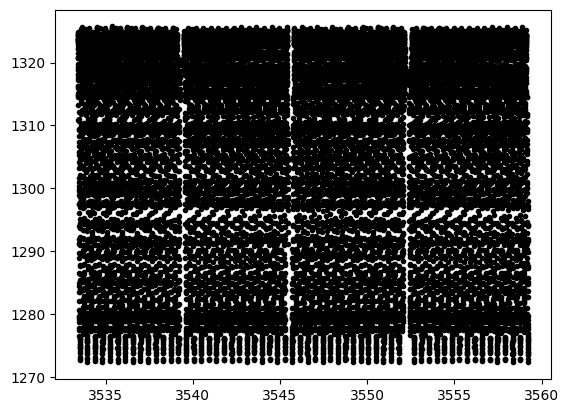

In [144]:
# Interpolate binned_folded_lc
time = big_lc.time.value
folded_time = big_lc.time.value % (2.*average_period.value)
mn_time = np.mean(folded_time)
interpolated_binned_folded_lc = np.interp(folded_time - mn_time, binned_folded_lc.time.value, binned_folded_lc.flux.value)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(time, interpolated_binned_folded_lc, marker='.', color='k')

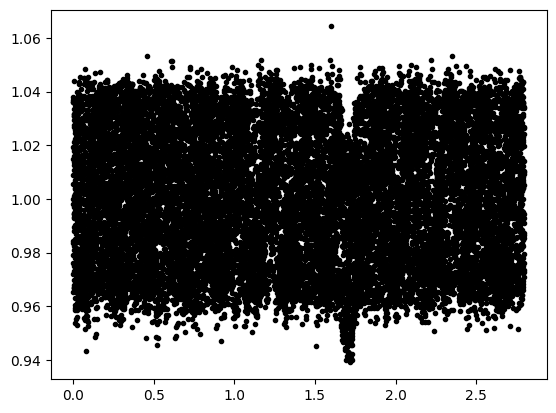

In [143]:
detrended_big_lc = big_lc.flux.value/interpolated_binned_folded_lc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(big_lc.time.value % orbital_period, detrended_big_lc, marker='.', color='k')